# To-do List
- convert from FWHM to true beam width
    - mostly done but still unsure about 3D geometry
    - also need to confirm the 1e6 correction

- use different method to calculate the beam width
    - check if the freq dependence still appears

- run a test to see if adding noise cause a systematic change in beam width

- ***REDUCED CHI SQUARED***
    - bad idea use least squares fit instead
    - calc the residuals then square them, then average them
        - weights further away points higher to highlight a bad fit

# (0) Set-up

In [2]:
import os
import numpy as np

from scipy import interpolate
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve

import datetime

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime
from astropy.coordinates import Angle

from matplotlib import pyplot as plt
from math import pi

In [3]:
pathtemplate = "C:/Users/jetso/Creative Cloud Files/Desktop/Uni/L-BASS"

filelist = []
for (dirpath, dirnames, filenames) in os.walk(pathtemplate):
    filelist.extend(filenames)
    break
print (filelist)

[]


# (1) Import Data
- Will first try with the 2022 data to compare to excel results
  - only using 18 Mar data but should **generalise the method into functions to work for any data**
- Then repeat with 2024 observation

## (1.1) Total and HI Powers

I use a class system here to make it easier to quickly view data.
I have a new form of data though and need to make it work again:
- I have folders for each date
- in each folder are 5 npy arrays
  - 4 spectrometer outputs
  - 1 for the datetime objects

In [4]:
class Transit:
    def __init__(self, date, dec_L, dec_mid, dec_R, horn, noon):
        self.date = date
        self.dec_mid = dec_mid
        self.dec_L = dec_L
        self.dec_R = dec_R
        self.horn = horn
        self.noon = noon
    def get_data(self):
        folder = os.path.join(pathtemplate,f"Data/{transit.date}")
        #print(os.listdir(folder))
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        a1p1 = np.load(os.path.join(folder, 'a1p1_bandpass.npy'), allow_pickle=True)
        a1p2 = np.load(os.path.join(folder, 'a1p2_bandpass.npy'), allow_pickle=True)
        a2p1 = np.load(os.path.join(folder, 'a2p1_bandpass.npy'), allow_pickle=True)
        a2p2 = np.load(os.path.join(folder, 'a2p2_bandpass.npy'), allow_pickle=True)
        power_array = np.stack((a2p1, a1p2, a1p1, a2p2))

        # a1p1, a2p2 = WEST, a1p2, a2p1 = EAST

        return datetimes, power_array

transit_list = [Transit('10th May 2024', 17.81, 17.82, 17.82, 'W', datetime.datetime(2024, 5, 10, 12, 5, 38)),
                Transit('11th May 2024', 18.06, 18.07, 18.08, 'W', datetime.datetime(2024, 5, 11, 12, 5, 36)),
                Transit('8th July 2024', 0, 22.38,0, 'E', datetime.datetime(2024, 5, 11, 12, 5, 36))]

transit = transit_list[0]
time, power = transit.get_data()

print(time.shape)
print(power.shape)

power_total = np.average(power[2,:,112:569], axis=1)
print(power_total.shape)
plt.plot(power_total)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/jetso/Creative Cloud Files/Desktop/Uni/L-BASS\\Data/10th May 2024\\datetimes.npy'

# (2) Finding FWHM

From ppt:
- differences in obs day accounted for by shifting and scaling amp
  - is this correct?
  - what if this has ignored a more fundamental issue?

- suggested solar flux variations not significant over transit
  - if they are how do we account for it?

- assumed the correction due to the Sun's transit not being flat is insignificant
  - if this is treated formally it may solve the discrepancy
  - has the movement of the Earth during the transit been accounted for?
    - obviously the rotation of Earth is the transit
    - but does its orbital motion need to be included too?
    - would this even been worthwhile doing? (too small an effect??)


## (2.2) Gaussian Fitting

Attempting to fit a gaussian and straight line combined...

In [ ]:
def w_a(values, uncer):
    x = np.average(values, weights=1/uncer**2)
    dx = 1/np.sqrt(np.sum(1/uncer**2))
    return x,dx

In [ ]:
def line_fitting(x_data, y_data, y_uncertainties):

    weights = 1. / y_uncertainties**2
    repeated_term = (np.sum(weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights)**2)

    slope = ((np.sum(weights) * np.sum(x_data * y_data * weights) - np.sum(x_data * weights) * np.sum(y_data * weights)) / repeated_term)
    slope_uncertainty = np.sqrt(np.sum(weights) / repeated_term)

    offset = ((np.sum(y_data * weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights) * np.sum(x_data * y_data * weights)) / repeated_term)
    offset_uncertainty = np.sqrt(np.sum(x_data**2 * weights) / repeated_term)

    return (np.array([slope, offset]), np.array([slope_uncertainty, offset_uncertainty]))

In [ ]:
def gaussian_with_baseline(x, a, b, c, d, m):
    return a*np.exp(-((x-b)**2)/(2*(c/(2*np.sqrt(2*np.log(2))))**2)) + m*x + d

def gaussian_with_baseline_fitting(x, y):
    p0 = np.array([np.max(y), np.argmax(y), 98, 10, 1])
    popt, pcov = scipy.optimize.curve_fit(gaussian_with_baseline, x, y, absolute_sigma=0, p0=p0)
    #absolute_sigma=0 to ensure uncertainties reflect the fitting
    return popt, pcov

In [ ]:
def gaussian(x, a, b, c, d):
    return a*np.exp(-((x-b)**2)/(2*(c/(2*np.sqrt(2*np.log(2))))**2)) + d

def gaussian_fitting(x, y):
    p0 = np.array([np.max(y), np.argmax(y), 98, 10])
    popt, pcov = scipy.optimize.curve_fit(gaussian, x, y, absolute_sigma=0, p0=p0)
    #absolute_sigma=0 to ensure uncertainties reflect the fitting
    return popt, pcov

In [ ]:
def janky_fitting(t, p, dec):
    #plt.plot(t,p)
    #plt.show()
    pk_loc, pk_dic = scipy.signal.find_peaks(p, height=10, prominence=5) # prominence stops the detection of secondary peaks
    pk_h = pk_dic['peak_heights']
    #print(f'peak index: {pk_loc}')
    #print(pk_dic)

    fwhm, fwhm_h, l_loc, r_loc = scipy.signal.peak_widths(p, pk_loc, rel_height=0.5) # finds the FWHM of the peak at peak_loc
    # fwhm is strictly the # of bins but as each is 1 min this is just the # of mins
    #print(f'fwhm: {fwhm} mins')
    #print(f'solar noon: {t[pk_loc[0]]}')
    #print(f'left half max: {t[0] + datetime.timedelta(minutes=l_loc[0])}')
    #print(f'right half max: {t[0] + datetime.timedelta(minutes=r_loc[0])}')
    return fwhm[0]*np.cos(dec)*360/(23.9345*60)

In [ ]:
def harry_plotter(t, p, parameters):
    plt.plot(t, p)
    plt.plot(t, gaussian_with_baseline(t, *parameters))

    plt.xlabel('time [mins]')
    plt.ylabel('power')
    plt.grid()
    #plt.show()
    return

In [ ]:
def calc_beam_width_with_baseline(t, p, dec):
    time_mins = np.array([(i - t[0]).total_seconds() / 60 for i in t])

    para, para_cov = gaussian_with_baseline_fitting(time_mins, p)
    para_err = np.sqrt(np.diag(para_cov))
    
    fwhm_deg_temp = para[2]*np.cos(dec)*360/(23.9345*60)
    fwhm_deg_err_temp = para_err[2]*np.cos(dec)*360/(23.9345*60)

    peak = datetime.timedelta(minutes=para[1]) + t[0]
    peak_err = para_err[1]
    pointing_diff_mins = abs(transit.noon-peak).total_seconds()/60
    pointing_diff_temp = pointing_diff_mins*np.cos(sol_dec)*360/(23.9345*60)
    pointing_diff_err_temp = peak_err*np.cos(sol_dec)*360/(23.9345*60)

    #harry_plotter(time_mins, p, para)
    #plt.show()

    return fwhm_deg_temp, fwhm_deg_err_temp, pointing_diff_temp, pointing_diff_err_temp, para[-1], para_err[-1], para[-2], para_err[-2]

In [ ]:
def calc_beam_width(t, p, dec):
    time_mins = np.array([(i - t[0]).total_seconds() / 60 for i in t])

    para, para_cov = gaussian_fitting(time_mins, p)
    para_err = np.sqrt(np.diag(para_cov))
    
    fwhm_deg_temp = para[2]*np.cos(dec)*360/(23.9345*60)
    fwhm_deg_err_temp = para_err[2]*np.cos(dec)*360/(23.9345*60)

    peak = datetime.timedelta(minutes=para[1]) + t[0]
    peak_err = para_err[1]
    pointing_diff_mins = abs(transit.noon-peak).total_seconds()/60
    pointing_diff_temp = pointing_diff_mins*np.cos(sol_dec)*360/(23.9345*60)
    pointing_diff_err_temp = peak_err*np.cos(sol_dec)*360/(23.9345*60)

    #harry_plotter(time_mins, p, para)
    #plt.show()

    return fwhm_deg_temp, fwhm_deg_err_temp, pointing_diff_temp, pointing_diff_err_temp

In [ ]:
def min_max(y):
    max = np.max(y)
    min = np.min(y)

    half_power = (max-min)/2
    print(half_power)

    return np.argmax(y), np.where((y-min)<half_power)[0]

4.392961543054975
42 95


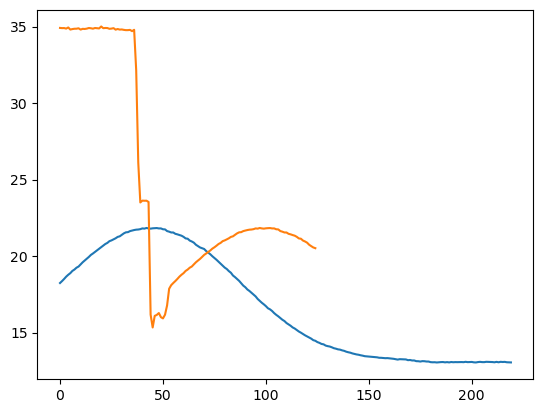

In [ ]:
peak, power_hp = min_max(power[0,150:370,300])
print(peak, power_hp[0])
plt.plot(power[0,150:370,300])
plt.plot(power[0,power_hp,300])

# Beamwidth (gaussian with baseline)

mean fwhm: 23.07066487078384 +/- 0.0007852353507750389 deg
[ 0.02086448 -6.3681821 ]
mean fwhm: 23.07180451859837 +/- 0.0007826977754274713 deg
[ 0.02124853 -6.90888889]


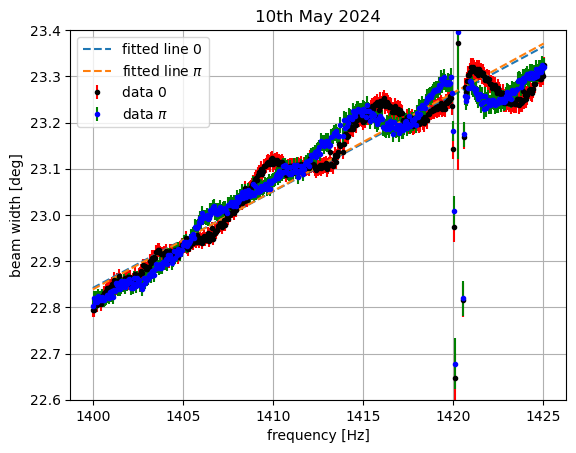

mean fwhm: 22.968801166663646 +/- 0.00112776722704996 deg
[ 0.018568   -3.24881957]
mean fwhm: 22.96570172001492 +/- 0.00112453537479689 deg
[ 0.01923652 -4.19287391]


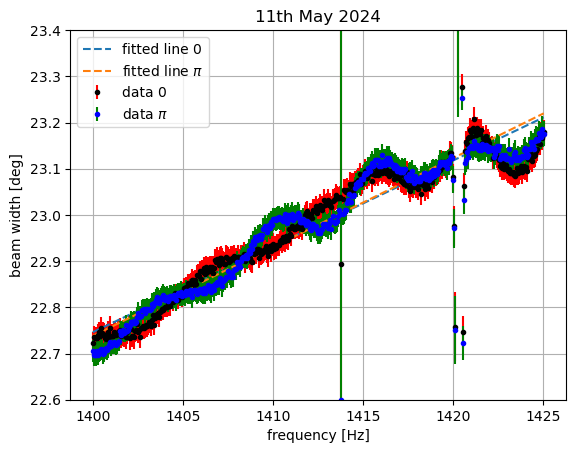

In [ ]:
colors = ['k.', 'r', 'b.', 'g']

for k in range(len(transit_list)-1):
    transit = transit_list[k]
    time, power = transit.get_data()

    sol_dec = transit.dec_mid*np.pi/180

    if transit.horn=='E':
        index = [0,1]
        factor = 0
    elif transit.horn=='W':
        index = [2,3]
        factor = 2

    for j in index:
        fwhm_deg = np.array([]) # empty array to store the FWHM values
        fwhm_deg_err = np.array([])

        power2 = power[j]

        for i in range(112, 569):
            power3 = power2[:,i]
            #power3 = np.reverse(power3)
            fwhm, fwhm_err,_,_,_,_,_,_ = calc_beam_width_with_baseline(time, power3, sol_dec)
            fwhm_deg = np.append(fwhm_deg, fwhm)
            fwhm_deg_err = np.append(fwhm_deg_err, fwhm_err)

        mean_fwhm_deg, mean_fwhm_deg_err = w_a(fwhm_deg, fwhm_deg_err)

        print(f'mean fwhm: {mean_fwhm_deg} +/- {mean_fwhm_deg_err} deg')

        if (j % 2) == 0:
            phase_label = '0'
        else:
            phase_label = r'$\pi$'

        freq = np.load(os.path.join(pathtemplate, 'Data/freq.npy'))[112:569]
        plt.errorbar(freq, fwhm_deg, fwhm_deg_err, fmt=colors[2*(j-factor)], ecolor=colors[2*(j-factor)+1], label = 'data '+phase_label)

        values, errors = line_fitting(freq, fwhm_deg, fwhm_deg_err)
        print(values)
        plt.plot(freq, values[0]*freq+values[1],'--', label='fitted line '+phase_label)

    plt.title(transit.date)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('beam width [deg]')
    plt.legend()
    plt.ylim(22.6,23.4)
    plt.grid()
    plt.show()


In [ ]:
angle_test_deg = 1
angle_test_mins = angle_test_deg*(23.9345*60)/(360*np.cos(sol_dec))
print(f'{angle_test_deg} deg = {angle_test_mins} mins')

time_test_mins = 11
time_test_deg = time_test_mins*np.cos(22.38*np.pi/180)*360/(23.9345*60)
print(f'{time_test_mins} mins = {time_test_deg} deg')

1 deg = 4.196039243242107 mins
11 mins = 2.5498261393348494 deg


# Pointing (gaussian with baseline)

mean pointing difference: 0.16219253016452342 +/- 0.0002943235961327884 deg
[ 2.18537941e-03 -2.92131614e+00]
mean pointing difference: 0.16406028788609145 +/- 0.00029336763865161114 deg
[ 1.98637177e-03 -2.63865176e+00]


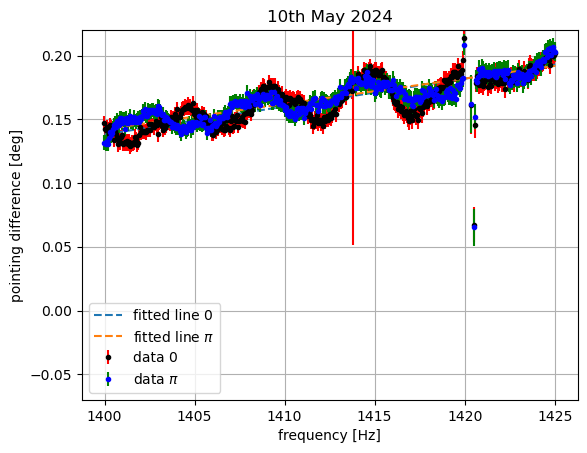

mean pointing difference: 0.028250823551909197 +/- 0.0004232357249816483 deg
[-1.68179499e-03  2.40293567e+00]
mean pointing difference: 0.02557882983492637 +/- 0.0004220284871150758 deg
[-1.52711034e-03  2.18161428e+00]


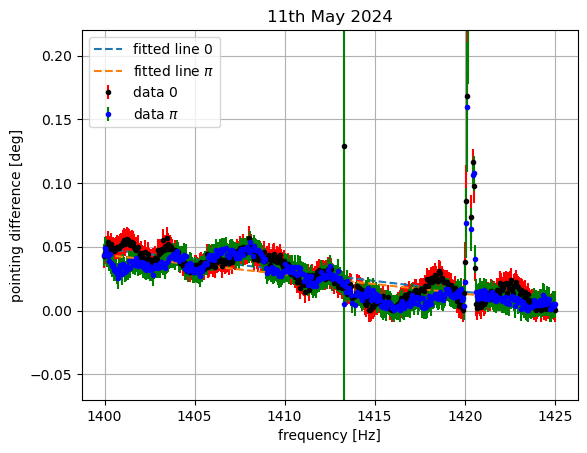

In [ ]:
colors = ['k.', 'r', 'b.', 'g']

for k in range(len(transit_list)-1):
    transit = transit_list[k]
    time, power = transit.get_data()

    sol_dec = transit.dec_mid*np.pi/180

    if transit.horn=='E':
        index = [0,1]
        factor = 0
    elif transit.horn=='W':
        index = [2,3]
        factor = 2

    for j in index:
        pointing = np.array([])
        pointing_err = np.array([])

        power2 = power[j]

        for i in range(112, 569):
            _, _, pnt, pnt_err,_,_,_,_ = calc_beam_width_with_baseline(time, power2[:,i], sol_dec)
            pointing = np.append(pointing, pnt)
            pointing_err = np.append(pointing_err, pnt_err)

        mean_pointing, mean_pointing_err = w_a(pointing, pointing_err)

        print(f'mean pointing difference: {mean_pointing} +/- {mean_pointing_err} deg')

        if (j % 2) == 0:
            phase_label = '0'
        else:
            phase_label = r'$\pi$'

        freq = np.load(os.path.join(pathtemplate, 'Data/freq.npy'))[112:569]
        plt.errorbar(freq, pointing, pointing_err, fmt=colors[2*(j-factor)], ecolor=colors[2*(j-factor)+1], label = 'data '+phase_label)

        values, errors = line_fitting(freq, pointing, pointing_err)
        print(values)
        plt.plot(freq, values[0]*freq+values[1],'--', label='fitted line '+phase_label)

    plt.title(transit.date)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('pointing difference [deg]')
    plt.legend()
    plt.ylim(-0.07,0.22)
    plt.grid()
    plt.show()


# Baseline (gaussian with baseline)

mean baseline: 0.00029796269175179314 +/- 5.578377625037789e-07
[-8.77429791e-06  1.26927662e-02]
mean baseline: 0.0002917611889388732 +/- 5.231492380647942e-07
[-6.62296630e-06  9.64583333e-03]


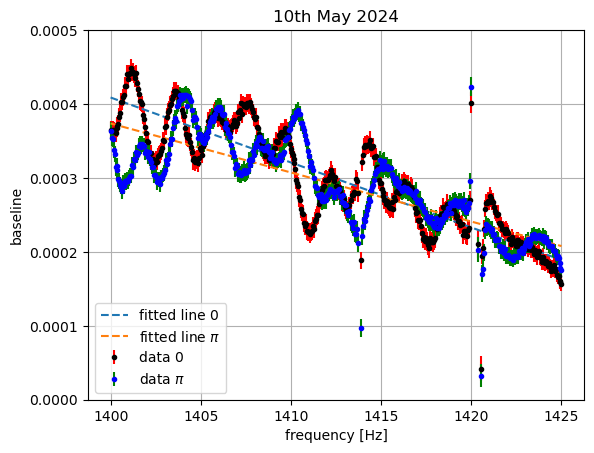

mean baseline: 0.00017677270270945172 +/- 8.715514579641736e-07
[-6.63454737e-06  9.55634544e-03]
mean baseline: 0.0001811834266600683 +/- 8.20717723327977e-07
[-5.26323110e-06  7.62000183e-03]


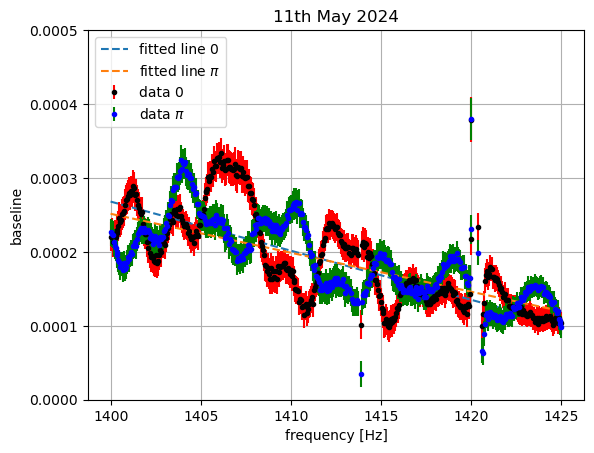

In [ ]:
colors = ['k.', 'r', 'b.', 'g']

for k in range(len(transit_list)-1):
    transit = transit_list[k]
    time, power = transit.get_data()

    sol_dec = transit.dec_mid*np.pi/180

    if transit.horn=='E':
        index = [0,1]
        factor = 0
    elif transit.horn=='W':
        index = [2,3]
        factor = 2

    for j in index:
        baseline = np.array([])
        baseline_err = np.array([])

        power2 = power[j]

        for i in range(112, 569):
            _,_,_,_, base, base_err,_,_ = calc_beam_width_with_baseline(time, power2[:,i], sol_dec)
            baseline = np.append(baseline, base)
            baseline_err = np.append(baseline_err, base_err)

        mean_baseline, mean_baseline_err = w_a(baseline, baseline_err)

        print(f'mean baseline: {mean_baseline} +/- {mean_baseline_err}')

        if (j % 2) == 0:
            phase_label = '0'
        else:
            phase_label = r'$\pi$'

        freq = np.load(os.path.join(pathtemplate, 'Data/freq.npy'))[112:569]
        plt.errorbar(freq, baseline, baseline_err, fmt=colors[2*(j-factor)], ecolor=colors[2*(j-factor)+1], label = 'data '+phase_label)

        values, errors = line_fitting(freq, baseline, baseline_err)
        print(values)
        plt.plot(freq, values[0]*freq+values[1],'--', label='fitted line '+phase_label)

    plt.title(transit.date)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('baseline')
    plt.legend()
    plt.ylim(0,0.0005)
    plt.grid()
    plt.show()

# Beamwidth (gaussian with corrected data)

Here I fit to a gaussian with a baseline as before, then subtract this baseline from the data. Then I refit a standard gaussian to the data to get a corrected beamwidth.

mean fwhm: 23.071018049161957 +/- 0.0007733116796536109 deg
[ 0.02085573 -6.3558331 ]
mean fwhm: 23.071851019914472 +/- 0.0007700902684198887 deg
[ 0.02125618 -6.91958184]


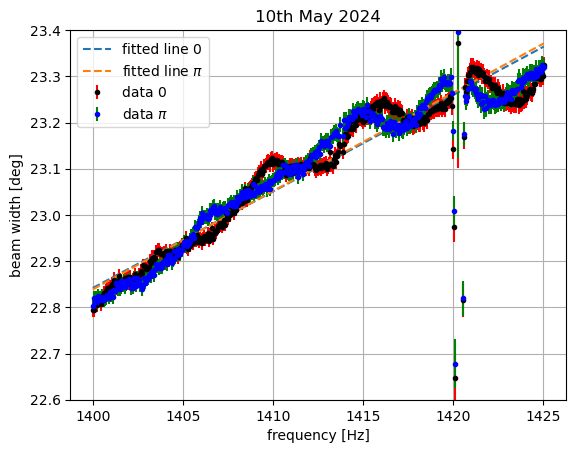

mean fwhm: 22.969056479226392 +/- 0.0011108432875417602 deg
[ 0.01856688 -3.24714942]
mean fwhm: 22.965877749024184 +/- 0.0011067163164201457 deg
[ 0.01924036 -4.19831545]


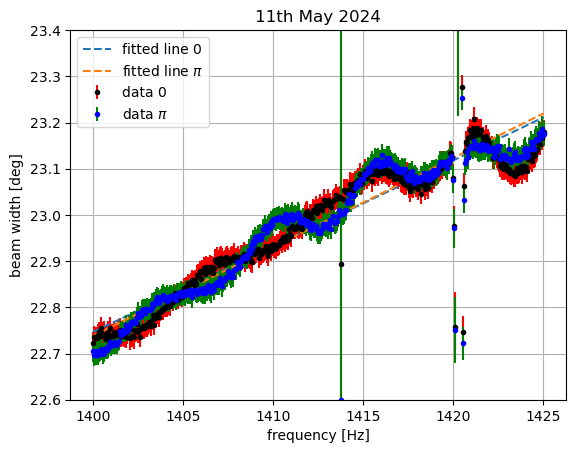

In [ ]:
colors = ['k.', 'r', 'b.', 'g']

for k in range(len(transit_list)-1):
    transit = transit_list[k]
    time, power = transit.get_data()

    time_mins = np.array([(i - time[0]).total_seconds() / 60 for i in time])

    sol_dec = transit.dec_mid*np.pi/180

    if transit.horn=='E':
        index = [0,1]
        factor = 0
    elif transit.horn=='W':
        index = [2,3]
        factor = 2

    for j in index:
        fwhm_deg = np.array([]) # empty array to store the FWHM values
        fwhm_deg_err = np.array([])

        power2 = power[j]

        for i in range(112, 569):
            _,_,_,_,base,_, offset,_ = calc_beam_width_with_baseline(time, power2[:,i], sol_dec)

            power3 = power2[:,i] - base*time_mins - offset

            fwhm, fwhm_err,_,_ = calc_beam_width(time, power3, sol_dec)

            fwhm_deg = np.append(fwhm_deg, fwhm)
            fwhm_deg_err = np.append(fwhm_deg_err, fwhm_err)

        mean_fwhm_deg, mean_fwhm_deg_err = w_a(fwhm_deg, fwhm_deg_err)

        print(f'mean fwhm: {mean_fwhm_deg} +/- {mean_fwhm_deg_err} deg')

        if (j % 2) == 0:
            phase_label = '0'
        else:
            phase_label = r'$\pi$'

        freq = np.load(os.path.join(pathtemplate, 'Data/freq.npy'))[112:569]
        plt.errorbar(freq, fwhm_deg, fwhm_deg_err, fmt=colors[2*(j-factor)], ecolor=colors[2*(j-factor)+1], label = 'data '+phase_label)

        values, errors = line_fitting(freq, fwhm_deg, fwhm_deg_err)
        print(values)
        plt.plot(freq, values[0]*freq+values[1],'--', label='fitted line '+phase_label)

    plt.title(transit.date)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('beam width [deg]')
    plt.legend()
    plt.ylim(22.6,23.4)
    plt.grid()
    plt.show()


# Normalised Fit

mean fwhm: 23.070332141277408 +/- 0.0007731727412604694 deg
[ 0.02087434 -6.38212688]
mean fwhm: 23.071879216683747 +/- 0.0007699021403673466 deg
[ 0.02124464 -6.90332313]


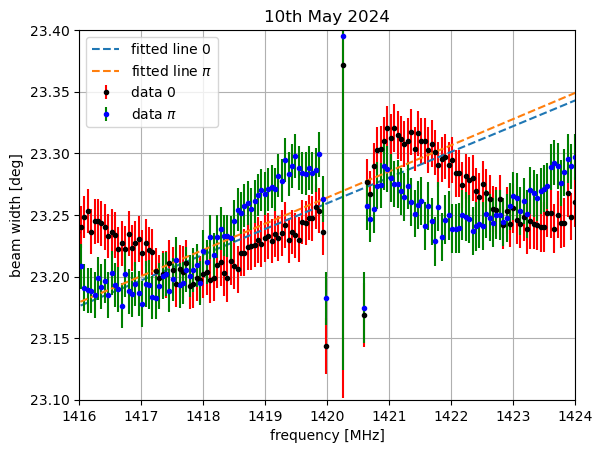

mean fwhm: 22.968709056890294 +/- 0.001110645091275846 deg
[ 0.01856197 -3.24046406]
mean fwhm: 22.965497474937923 +/- 0.0011058525885562721 deg
[ 0.01924221 -4.20091703]


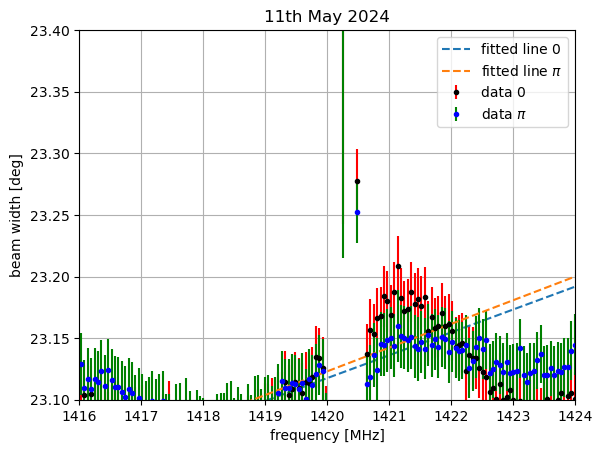

In [ ]:
colors = ['k.', 'r', 'b.', 'g']

for k in range(len(transit_list)-1):
    transit = transit_list[k]
    time, power = transit.get_data()

    time_mins = np.array([(i - time[0]).total_seconds() / 60 for i in time])

    sol_dec = transit.dec_mid*np.pi/180

    if transit.horn=='E':
        index = [0,1]
        factor = 0
    elif transit.horn=='W':
        index = [2,3]
        factor = 2

    for j in index:
        fwhm_deg = np.array([]) # empty array to store the FWHM values
        fwhm_deg_err = np.array([])

        power2 = power[j]

        for i in range(112, 569):
            power3 = power2[:,i]
            mean = np.mean(power3)
            power3 /= mean

            _,_,_,_,base,_, offset,_ = calc_beam_width_with_baseline(time, power3, sol_dec)

            power3 -= base*time_mins + offset

            fwhm, fwhm_err,_,_ = calc_beam_width(time, power3, sol_dec)

            fwhm_deg = np.append(fwhm_deg, fwhm)
            fwhm_deg_err = np.append(fwhm_deg_err, fwhm_err)

        mean_fwhm_deg, mean_fwhm_deg_err = w_a(fwhm_deg, fwhm_deg_err)

        print(f'mean fwhm: {mean_fwhm_deg} +/- {mean_fwhm_deg_err} deg')

        if (j % 2) == 0:
            phase_label = '0'
        else:
            phase_label = r'$\pi$'

        freq = np.load(os.path.join(pathtemplate, 'Data/freq.npy'))[112:569]
        plt.errorbar(freq, fwhm_deg, fwhm_deg_err, fmt=colors[2*(j-factor)], ecolor=colors[2*(j-factor)+1], label = 'data '+phase_label)

        values, errors = line_fitting(freq, fwhm_deg, fwhm_deg_err)
        print(values)
        plt.plot(freq, values[0]*freq+values[1],'--', label='fitted line '+phase_label)

    plt.title(transit.date)
    plt.xlabel('frequency [MHz]')
    plt.ylabel('beam width [deg]')
    plt.legend()
    plt.xlim(1416,1424)
    plt.ylim(23.1,23.4)
    plt.grid()
    plt.show()


# 10 min bin

mean fwhm: 23.070332141277408 +/- 0.0007731727412604694 deg
[ 0.02087434 -6.38212688]
mean fwhm: 23.071879216683747 +/- 0.0007699021403673466 deg
[ 0.02124464 -6.90332313]


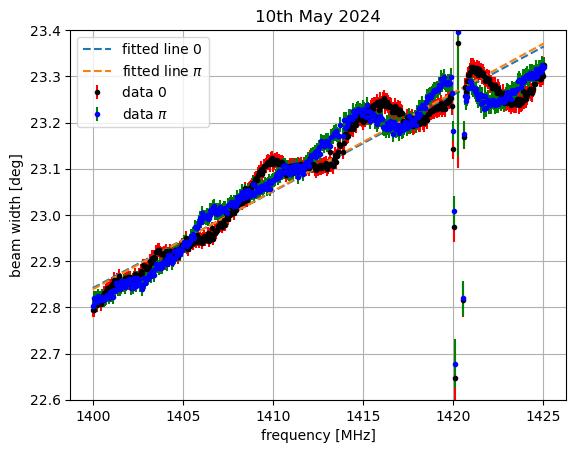

mean fwhm: 22.968709056890294 +/- 0.001110645091275846 deg
[ 0.01856197 -3.24046406]
mean fwhm: 22.965497474937923 +/- 0.0011058525885562721 deg
[ 0.01924221 -4.20091703]


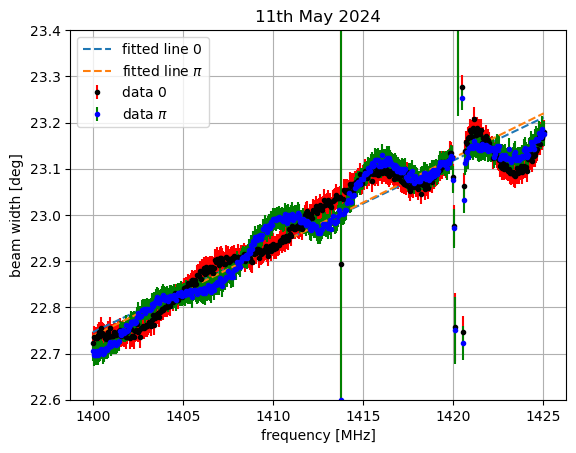

In [ ]:
colors = ['k.', 'r', 'b.', 'g']

for k in range(len(transit_list)-1):
    transit = transit_list[k]
    time, power = transit.get_data()

    time_mins = np.array([(i - time[0]).total_seconds() / 60 for i in time])

    sol_dec = transit.dec_mid*np.pi/180

    if transit.horn=='E':
        index = [0,1]
        factor = 0
    elif transit.horn=='W':
        index = [2,3]
        factor = 2

    for j in index:
        fwhm_deg = np.array([]) # empty array to store the FWHM values
        fwhm_deg_err = np.array([])

        power2 = power[j]

        for i in range(112, 569):
            power3 = power2[:,i]
            mean = np.mean(power3)
            power3 /= mean

            _,_,_,_,base,_, offset,_ = calc_beam_width_with_baseline(time, power3, sol_dec)

            power3 -= base*time_mins + offset

            fwhm, fwhm_err,_,_ = calc_beam_width(time, power3, sol_dec)

            fwhm_deg = np.append(fwhm_deg, fwhm)
            fwhm_deg_err = np.append(fwhm_deg_err, fwhm_err)

        mean_fwhm_deg, mean_fwhm_deg_err = w_a(fwhm_deg, fwhm_deg_err)

        print(f'mean fwhm: {mean_fwhm_deg} +/- {mean_fwhm_deg_err} deg')

        if (j % 2) == 0:
            phase_label = '0'
        else:
            phase_label = r'$\pi$'

        freq = np.load(os.path.join(pathtemplate, 'Data/freq.npy'))[112:569]
        plt.errorbar(freq, fwhm_deg, fwhm_deg_err, fmt=colors[2*(j-factor)], ecolor=colors[2*(j-factor)+1], label = 'data '+phase_label)

        values, errors = line_fitting(freq, fwhm_deg, fwhm_deg_err)
        print(values)
        plt.plot(freq, values[0]*freq+values[1],'--', label='fitted line '+phase_label)

    plt.title(transit.date)
    plt.xlabel('frequency [MHz]')
    plt.ylabel('beam width [deg]')
    plt.legend()
    plt.ylim(22.6,23.4)
    plt.grid()
    plt.show()

(10799000, 100)
[ 4.91355596e-01 -6.04121694e+02]


(100.0, 110.0)

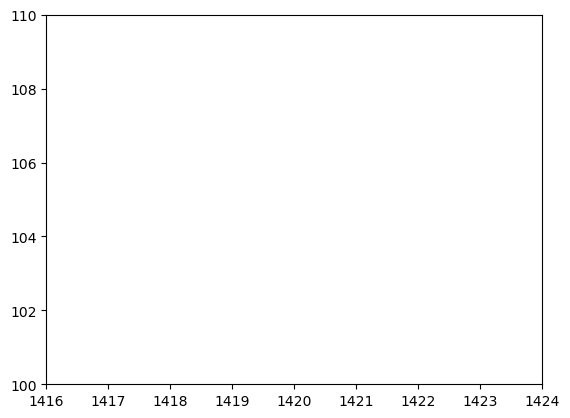

In [ ]:
filename = os.path.join(pathtemplate,f"Data/bandpass_powers_20240718.npy")
#print(os.listdir(folder))
power = np.load(filename, allow_pickle=True)
print(power.shape)
power = power[0:10740000, :]

#10740000

sol_dec = 21.06

fwhm_deg = np.array([]) # empty array to store the FWHM values
fwhm_deg_err = np.array([])

time_mins = np.arange(0,179,1)

power2 = power[:,50]
power2 = np.sum(power2.reshape(int(len(power2)/60000),60000), axis=1)
power2 = power2[58:]
plt.plot(power2,'k.')

for i in range(len(power[0,:])):
    power_temp = power[:,i]
    power_temp = np.sum(power_temp.reshape(int(len(power_temp)/60000),60000), axis=1)
    para, para_cov = gaussian_fitting(time_mins, power_temp)
    power2 = power_temp
    power2 = power2[60:]
    para, para_cov = gaussian_fitting(time_mins[60:], power2)
    para_err = np.sqrt(np.diag(para_cov))
    fwhm_deg = np.append(fwhm_deg, para[2])
    fwhm_deg_err = np.append(fwhm_deg_err, para_err[2])

#mean_fwhm_deg, mean_fwhm_deg_err = w_a(fwhm_deg, fwhm_deg_err)
#print(f'mean fwhm: {mean_fwhm_deg} +/- {mean_fwhm_deg_err} deg')

freq = np.arange(1415,1425,0.1)
plt.errorbar(freq, fwhm_deg, fwhm_deg_err, fmt='k.', ecolor='r')
values, errors = line_fitting(freq, fwhm_deg, fwhm_deg_err)
print(values)
plt.plot(freq, values[0]*freq+values[1],'--', label='fitted line '+phase_label)
plt.xlim(1416,1424)
plt.ylim(100,110)

# Janky

mean fwhm: 23.08865147624643 deg
mean fwhm: 23.08865147624643 deg


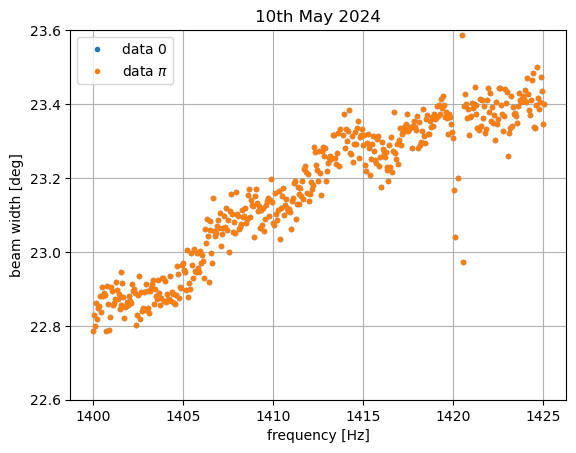

mean fwhm: 23.002319455159764 deg
mean fwhm: 23.002319455159764 deg


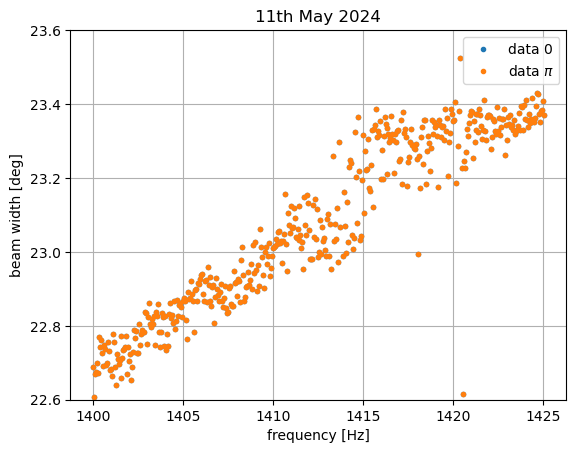

In [ ]:
colors = ['k.', 'r', 'b.', 'g']

for k in range(len(transit_list)-1):
    transit = transit_list[k]
    time, power = transit.get_data()

    sol_dec = transit.dec_mid*np.pi/180

    if transit.horn=='E':
        index = [0,1]
        factor = 0
    elif transit.horn=='W':
        index = [2,3]
        factor = 2

    for j in index:
        fwhm_deg = np.array([]) # empty array to store the FWHM values

        power2 = power[3]

        for i in range(112, 569):
            fwhm = janky_fitting(time, power2[:,i], sol_dec)
            fwhm_deg = np.append(fwhm_deg, fwhm)

        mean_fwhm_deg = np.average(fwhm_deg)

        print(f'mean fwhm: {mean_fwhm_deg} deg')

        if (j % 2) == 0:
            phase_label = '0'
        else:
            phase_label = r'$\pi$'

        freq = np.load(os.path.join(pathtemplate, 'Data/freq.npy'))[112:569]
        #freq = np.linspace(1400,1425,len(fwhm_deg))
        plt.plot(freq, fwhm_deg, '.', label = 'data '+phase_label)

    plt.title(transit.date)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('beam width [deg]')
    plt.legend()
    plt.ylim(22.6,23.6)
    plt.grid()
    plt.show()